In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer
from scipy.stats import mstats
from sklearn.metrics import mean_squared_error



pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load files
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sample_submission = pd.read_csv('SampleSubmission.csv')

In [3]:
# Preview the first five rows of the train set
display(train.shape)
display(test.shape)

(8071, 80)

(2783, 79)

In [4]:
# Preview the first five rows of the test set
test.head()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle
0,id_ihxgrbq8bw,64f9d17ab9e98d001ac9e882,5.61252,-0.22955,Accra,Ghana,2023-09-06,13,-0.000072,0.762543,-0.000055,0.079645,-100.330299,26.926420,-86.879776,25.512329,-0.000028,9.0,0.043537,2825.323242,1.000000,829406.9375,-97.787621,26.897718,-86.884308,25.509418,0.000055,0.000016,0.000040,0.000109,9582.745678,-0.258421,0.019749,829420.312500,-100.330299,26.926420,-86.879776,25.512329,0.000243,1.112240,0.000213,0.079645,25.512329,-86.879776,26.926420,-100.330299,-0.258422,829420.312500,-100.330299,26.926420,-86.879776,25.512329,0.126056,2.243713,0.286278,230.244171,0.079324,-100.330299,26.926420,-86.879776,25.512329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043065,74217.403083,2710.544562,83569.504246,1710.544483,3.063105,0.263193,-100.317077,27.059646,-86.885670,25.530511
1,id_dg6s4fhiwe,64f9d17ab9e98d001ac9e882,5.61252,-0.22955,Accra,Ghana,2023-09-07,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.036341,2604.788330,1584.809692,829328.6250,70.753090,11.428769,-87.764297,20.935318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.408162,829340.750000,76.400116,11.171532,-87.726566,20.951560,0.126282,2.136400,0.273757,230.184377,0.613266,76.400116,11.171532,-87.726566,20.951560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,id_f7hwwtmuzp,64f9d17ab9e98d001ac9e882,5.61252,-0.22955,Accra,Ghana,2023-09-08,13,-0.000051,1.004265,-0.000051,0.163160,73.117264,43.112466,-89.089083,16.417355,-0.000023,9.0,0.037453,3046.3140

In [5]:
# Preview the first five rows of the sample submission file
sample_submission.head()

,id,pm2_5
0,id_ihxgrbq8bw,0
1,id_dg6s4fhiwe,0
2,id_f7hwwtmuzp,0
3,id_ioese5awdg,0
4,id_hdw320zpls,0


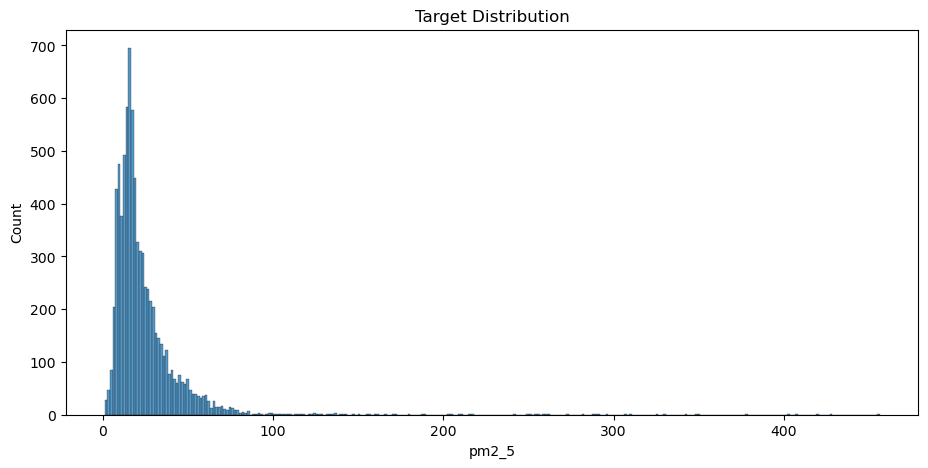

In [6]:
# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(train.pm2_5)
plt.title('Target Distribution')
plt.show()

- From the target distribution histogram we can see that the distribution is skewed to the right.
- Some processing of the target is recommended

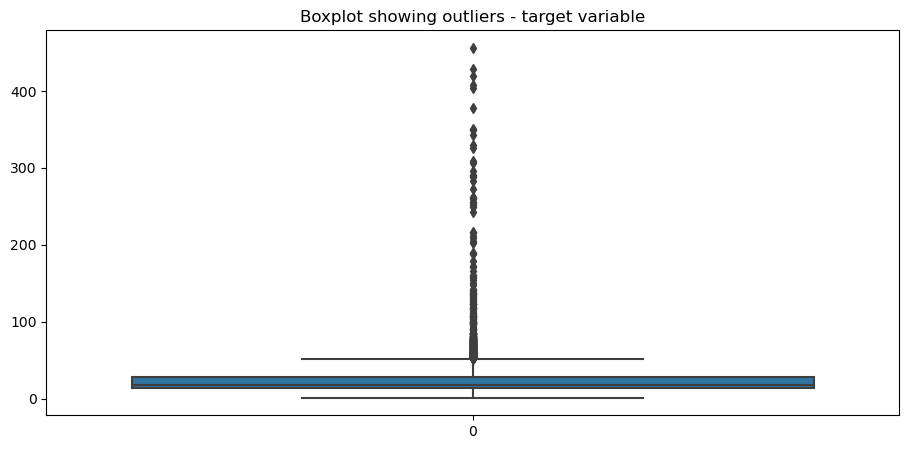

In [7]:
# Check for outliers in the target variable
plt.figure(figsize = (11, 5))
sns.boxplot(train.pm2_5)
plt.title('Boxplot showing outliers - target variable')
plt.show()

- The target variable has some outliers that are beyond the 180 mark.
- Outliers can be handled via
  - Dropping them
  - Cap outliers - set a maximum
  - Assign a new value to the outliers
  - Transform the target variable


## Handling Missing Values 

In [8]:
missing_values = ((train.isna().sum())/(len(train))) * 100
missing_values_sorted = missing_values.sort_values(ascending = False)
missing_values_sorted

uvaerosollayerheight_aerosol_height                         94.709454
uvaerosollayerheight_solar_zenith_angle                     94.709454
uvaerosollayerheight_solar_azimuth_angle                    94.709454
uvaerosollayerheight_sensor_azimuth_angle                   94.709454
uvaerosollayerheight_sensor_zenith_angle                    94.709454
uvaerosollayerheight_aerosol_optical_depth                  94.709454
uvaerosollayerheight_aerosol_pressure                       94.709454
nitrogendioxide_no2_slant_column_number_density             61.541321
nitrogendioxide_no2_column_number_density                   61.541321
nitrogendioxide_tropospheric_no2_column_number_density      61.541321
nitrogendioxide_stratospheric_no2_column_number_density     61.541321
nitrogendioxide_sensor_altitude                             61.541321
nitrogendioxide_tropopause_pressure                         61.541321
nitrogendioxide_absorbing_aerosol_index                     61.541321
nitrogendioxide_clou

In [9]:
missing_values = ((test.isna().sum())/(len(test))) * 100
missing_values_sorted = missing_values.sort_values(ascending = False)
missing_values_sorted

uvaerosollayerheight_aerosol_pressure                       97.700323
uvaerosollayerheight_aerosol_optical_depth                  97.700323
uvaerosollayerheight_sensor_zenith_angle                    97.700323
uvaerosollayerheight_sensor_azimuth_angle                   97.700323
uvaerosollayerheight_solar_azimuth_angle                    97.700323
uvaerosollayerheight_solar_zenith_angle                     97.700323
uvaerosollayerheight_aerosol_height                         97.700323
cloud_cloud_base_pressure                                   45.957600
cloud_cloud_fraction                                        45.957600
cloud_cloud_top_pressure                                    45.957600
cloud_cloud_top_height                                      45.957600
cloud_solar_zenith_angle                                    45.957600
cloud_solar_azimuth_angle                                   45.957600
cloud_sensor_zenith_angle                                   45.957600
cloud_sensor_azimuth

In [10]:
# Drop columns with more than 50% missing values
threshold = 0.8
train_df = train.loc[:, train.isnull().mean() < threshold]
test_df = test.loc[:, test.isnull().mean() < threshold]

In [11]:
# Identify the group column
group_col = 'site_id'

# Separate numerical and categorical columns
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.difference(['pm2_5'])
categorical_cols = train_df.select_dtypes(exclude=[np.number]).columns

# Impute numerical columns
for column in numerical_cols:
    if column != group_col:
        print(f"Imputing numerical column: {column}")
        mean_impute = train_df.groupby(group_col)[column].transform('median')
        train_df[column] = train_df[column].fillna(mean_impute)
        train_df[column] = train_df[column].fillna(train_df[column].mean())

        mean_impute_test = test_df.groupby(group_col)[column].transform('median')
        test_df[column] = test_df[column].fillna(mean_impute_test)
        test_df[column] = test_df[column].fillna(test_df[column].mean())

# Impute categorical columns
for column in categorical_cols:
    if column != group_col:
        print(f"Imputing categorical column: {column}")
        mode_impute = train_df.groupby(group_col)[column].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        train_df[column] = train_df[column].fillna(train_df[group_col].map(mode_impute))
        train_df[column] = train_df[column].fillna(train_df[column].mode().iloc[0] if not train_df[column].mode().empty else 'missing')

        mode_impute_test = test_df.groupby(group_col)[column].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
        test_df[column] = test_df[column].fillna(test_df[group_col].map(mode_impute_test))
        test_df[column] = test_df[column].fillna(test_df[column].mode().iloc[0] if not test_df[column].mode().empty else 'missing')


Imputing numerical column: carbonmonoxide_cloud_height
Imputing numerical column: carbonmonoxide_co_column_number_density
Imputing numerical column: carbonmonoxide_h2o_column_number_density
Imputing numerical column: carbonmonoxide_sensor_altitude
Imputing numerical column: carbonmonoxide_sensor_azimuth_angle
Imputing numerical column: carbonmonoxide_sensor_zenith_angle
Imputing numerical column: carbonmonoxide_solar_azimuth_angle
Imputing numerical column: carbonmonoxide_solar_zenith_angle
Imputing numerical column: cloud_cloud_base_height
Imputing numerical column: cloud_cloud_base_pressure
Imputing numerical column: cloud_cloud_fraction
Imputing numerical column: cloud_cloud_optical_depth
Imputing numerical column: cloud_cloud_top_height
Imputing numerical column: cloud_cloud_top_pressure
Imputing numerical column: cloud_sensor_azimuth_angle
Imputing numerical column: cloud_sensor_zenith_angle
Imputing numerical column: cloud_solar_azimuth_angle
Imputing numerical column: cloud_sola

In [12]:

# Ensure no missing values remain
assert train_df.isnull().sum().sum() == 0, "There are still missing values in the training set."
assert test_df.isnull().sum().sum() == 0, "There are still missing values in the testing set."

print("Imputation complete and verified!")

Imputation complete and verified!


### Using interquartile range to check for outliers 

In [13]:
# Calculating the IQR for numerical columns
for column in numerical_cols:
    if column != 'pm2_5':  # Exclude 'pm2_5' column
        Q1 = train_df[column].quantile(0.25)
        Q3 = train_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = ((train_df[column] < lower_bound) | (train_df[column] > upper_bound)).sum()
        print(f"Outliers in {column}: {outliers}")


Outliers in carbonmonoxide_cloud_height: 1065
Outliers in carbonmonoxide_co_column_number_density: 862
Outliers in carbonmonoxide_h2o_column_number_density: 812
Outliers in carbonmonoxide_sensor_altitude: 1062
Outliers in carbonmonoxide_sensor_azimuth_angle: 0
Outliers in carbonmonoxide_sensor_zenith_angle: 1299
Outliers in carbonmonoxide_solar_azimuth_angle: 0
Outliers in carbonmonoxide_solar_zenith_angle: 1225
Outliers in cloud_cloud_base_height: 387
Outliers in cloud_cloud_base_pressure: 51
Outliers in cloud_cloud_fraction: 0
Outliers in cloud_cloud_optical_depth: 1025
Outliers in cloud_cloud_top_height: 387
Outliers in cloud_cloud_top_pressure: 57
Outliers in cloud_sensor_azimuth_angle: 0
Outliers in cloud_sensor_zenith_angle: 876
Outliers in cloud_solar_azimuth_angle: 0
Outliers in cloud_solar_zenith_angle: 1095
Outliers in cloud_surface_albedo: 369
Outliers in formaldehyde_cloud_fraction: 1732
Outliers in formaldehyde_hcho_slant_column_number_density: 1262
Outliers in formaldehyd

In [14]:
# Calculating the IQR for numerical columns
for column in numerical_cols:
    if column != 'pm2_5':  # Exclude 'pm2_5' column
        Q1 = test_df[column].quantile(0.25)
        Q3 = test_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = ((test_df[column] < lower_bound) | (test_df[column] > upper_bound)).sum()
        print(f"Outliers in {column}: {outliers}")


Outliers in carbonmonoxide_cloud_height: 0
Outliers in carbonmonoxide_co_column_number_density: 439
Outliers in carbonmonoxide_h2o_column_number_density: 213
Outliers in carbonmonoxide_sensor_altitude: 16
Outliers in carbonmonoxide_sensor_azimuth_angle: 0
Outliers in carbonmonoxide_sensor_zenith_angle: 170
Outliers in carbonmonoxide_solar_azimuth_angle: 0
Outliers in carbonmonoxide_solar_zenith_angle: 291
Outliers in cloud_cloud_base_height: 283
Outliers in cloud_cloud_base_pressure: 304
Outliers in cloud_cloud_fraction: 315
Outliers in cloud_cloud_optical_depth: 230
Outliers in cloud_cloud_top_height: 316
Outliers in cloud_cloud_top_pressure: 298
Outliers in cloud_sensor_azimuth_angle: 0
Outliers in cloud_sensor_zenith_angle: 538
Outliers in cloud_solar_azimuth_angle: 0
Outliers in cloud_solar_zenith_angle: 400
Outliers in cloud_surface_albedo: 35
Outliers in formaldehyde_cloud_fraction: 0
Outliers in formaldehyde_hcho_slant_column_number_density: 147
Outliers in formaldehyde_sensor_a

#### Handling outliers for train set

In [15]:
# Define the percentile thresholds for winsorization
lower_percentile = 0.05  # 5th percentile
upper_percentile = 0.95  # 95th percentile

# Apply winsorization
train_df_winsorized = mstats.winsorize(train_df[column], limits=[lower_percentile, upper_percentile])

# Replace the column in the DataFrame with the winsorized values
train_df[column] = train_df_winsorized

#### Handling outliers for test data

In [16]:
# Define the percentile thresholds for winsorization
lower_percentile = 0.05  # 5th percentile
upper_percentile = 0.95  # 95th percentile

# Apply winsorization
test_df_winsorized = mstats.winsorize(test_df[column], limits=[lower_percentile, upper_percentile])

# Replace the column in the DataFrame with the winsorized values
test_df[column] = test_df_winsorized

In [17]:
# Calculating the IQR for numerical columns
for column in numerical_cols:
    if column != 'pm2_5':  # Exclude 'pm2_5' column
        Q1 = train_df[column].quantile(0.25)
        Q3 = train_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = ((train_df[column] < lower_bound) | (train_df[column] > upper_bound)).sum()
        print(f"Outliers in {column}: {outliers}")


Outliers in carbonmonoxide_cloud_height: 1065
Outliers in carbonmonoxide_co_column_number_density: 862
Outliers in carbonmonoxide_h2o_column_number_density: 812
Outliers in carbonmonoxide_sensor_altitude: 1062
Outliers in carbonmonoxide_sensor_azimuth_angle: 0
Outliers in carbonmonoxide_sensor_zenith_angle: 1299
Outliers in carbonmonoxide_solar_azimuth_angle: 0
Outliers in carbonmonoxide_solar_zenith_angle: 1225
Outliers in cloud_cloud_base_height: 387
Outliers in cloud_cloud_base_pressure: 51
Outliers in cloud_cloud_fraction: 0
Outliers in cloud_cloud_optical_depth: 1025
Outliers in cloud_cloud_top_height: 387
Outliers in cloud_cloud_top_pressure: 57
Outliers in cloud_sensor_azimuth_angle: 0
Outliers in cloud_sensor_zenith_angle: 876
Outliers in cloud_solar_azimuth_angle: 0
Outliers in cloud_solar_zenith_angle: 1095
Outliers in cloud_surface_albedo: 369
Outliers in formaldehyde_cloud_fraction: 1732
Outliers in formaldehyde_hcho_slant_column_number_density: 1262
Outliers in formaldehyd

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 73 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   id                                                        8071 non-null   object 
 1   site_id                                                   8071 non-null   object 
 2   site_latitude                                             8071 non-null   float64
 3   site_longitude                                            8071 non-null   float64
 4   city                                                      8071 non-null   object 
 5   country                                                   8071 non-null   object 
 6   date                                                      8071 non-null   object 
 7   hour                                                      8071 non-null   int64  
 8   sulphurdioxide_so2

### Dealing with the date column

In [19]:
# Convert the 'date' column to datetime format
train_df['date'] = pd.to_datetime(train_df['date'])

# Extract year, month, week from the 'date' column
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['week'] = train_df['date'].dt.isocalendar().week

In [20]:
# Convert the 'date' column to datetime format
test_df['date'] = pd.to_datetime(test_df['date'])

# Extract year, month, week from the 'date' column
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['week'] = test_df['date'].dt.isocalendar().week

In [21]:
col_drops = ['date', 'site_id', 'id']
test_df = test_df.drop(col_drops, axis=1)
train_df = train_df.drop(col_drops, axis=1)
display(train_df.shape)
display(test_df.shape)

(8071, 72)

(2783, 71)

### Encoding the city and country columns

In [22]:
# mapping the two columns
city_mapping = {'Kampala': 0, 'Nairobi': 1,
                'Lagos': 2, 'Bujumbura':3,
               'Kisumu':4, 'Gulu':5,
                'Accra':6, 'Yaoundé':7
} 
country_mapping = {
    'Uganda':0, 'Burundi':1, 
    'Kenya':2, 'Nigeria':3,
    'Cameroon':4, 'Ghana':5
}

In [23]:
# Replace 'outcome' values with numeric values
train_df['city'] = train_df['city'].replace(city_mapping)
test_df['city'] = test_df['city'].replace(city_mapping)

#country encoding mapping
train_df['country'] = train_df['country'].replace(country_mapping)
test_df['country'] = test_df['country'].replace(country_mapping)

In [24]:
display(train_df.head())
display(test_df.head())

,site_latitude,site_longitude,city,country,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,year,week
0,6.53257,3.39936,2,3,13,0.000024,0.558670,0.000019,0.109982,70.104246,47.564081,-142.719607,34.455680,0.000010,10,0.055301,2588.038696,1089.183248,828970.250000,68.446892,48.228082,-143.206551,33.176226,0.000111,0.000080,0.000032,0.000190,8614.462703,0.619377,0.097151,829096.375,-12.893481,47.564081,-142.719607,35.306790,0.000310,0.887255,0.000234,0.153496,33.427488,-143.480164,49.084085,70.106598,0.052301,828817.9375,-100.805145,21.720518,-123.523796,16.437775,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,0.247246,61995.007813,4217.259521,69841.425781,3217.259766,9.206095,0.154280,-95.877388,54.058586,-133.699845,39.577734,12.015000,2023,43
1,6.53257,3.39936,2,3,12,0.000024,0.558670,0.000019,0.109982,70.104246,47.564081,-142.719607,34.455680,0.000010,11,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,0.000111,0.000080,0.000032,0.000190,8614.462703,0.619377,0.097151,829096.375,-12.893481,47.564081,-142.719607,35.306790,0.000214,1.462390,0.000240,0.359150,26.525513,-143.480164,59.220097,70.875954,-0.315206,828578.6250,70.875954,59.220097,-143.480164,16.437775,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,0.247246,61995.007813,4217.259521,69841.425781,3217.259766,9.206095,0.154280,-95.877388,54.058586,-133.699845,39.577734,42.267200,2023,44
2,6.53257,3.39936,2,3,13,0.000024,0.558670,0.000019,0.109982,70.104246,47.564081,-142.719607,34.455680,0.000010,11,0.055301,2588.038696,1089.183248,828970.250000,68.446892,48.228082,-143.206551,33.176226,0.000111,0.000080,0.000032,0.000190,8614.462703,0.619377,0.097151,829096.375,-12.893481,47.564081,-142.719607,35.306790,0.000310,0.887255,0.000234,0.153496,33.427488,-14

,site_latitude,site_longitude,city,country,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,year,week
0,5.61252,-0.22955,6,5,13,-0.000072,0.762543,-0.000055,0.079645,-100.330299,26.926420,-86.879776,25.512329,-0.000028,9,0.043537,2825.323242,1.000000,829406.9375,-97.787621,26.897718,-86.884308,25.509418,0.000055,0.000016,0.000040,0.000109,9582.745678,-0.258421,0.019749,829420.312500,-100.330299,26.926420,-86.879776,25.512329,0.000243,1.112240,0.000213,0.079645,25.512329,-86.879776,26.926420,-100.330299,-0.258422,829420.312500,-100.330299,26.926420,-86.879776,18.004797,0.126056,2.243713,0.286278,230.244171,0.079324,-100.330299,26.926420,-86.879776,25.512329,0.043065,74217.403083,2710.544562,83569.504246,1710.544483,3.063105,0.263193,-100.317077,27.059646,-86.885670,25.530511,2023,36
1,5.61252,-0.22955,6,5,13,0.000097,0.659439,0.000052,0.089031,70.078751,50.179405,-133.470708,31.426330,0.000022,9,0.036341,2604.788330,1584.809692,829328.6250,70.753090,11.428769,-87.764297,20.935318,0.000063,0.000030,0.000033,0.000137,8614.466589,0.369843,0.038091,828980.937500,-96.239784,46.600380,-133.091582,32.496479,0.000194,1.072961,0.000148,0.098550,31.828811,-133.251167,51.678408,70.059709,-0.408162,829340.750000,76.400116,11.171532,-87.726566,18.004797,0.126282,2.136400,0.273757,230.184377,0.613266,76.400116,11.171532,-87.726566,20.951560,0.171229,56970.398438,4951.748535,64716.386719,3951.748291,6.390105,0.258624,70.039436,53.184719,-133.105549,29.519972,2023,36
2,5.61252,-0.22955,6,5,13,-0.000051,1.004265,-0.000051,0.163160,73.117264,43.112466,-89.089083,16.417355,-0.000023,9,0.037453,3046.314001,90.699029,829194.5625,71.272375,43.172868,-88.964294,16.440554,0.000062,0.000027,0.000036,0.000134,9582.743944,-0.115200,0.163328,829204.480816,73.117264,43.112466,-89.089083,16.417355,0.000145,1.345840,0.000127,0.163160,16.417355,-89.089083,43.112466,73.11

In [25]:
# Select X and y features for modelling
X = train_df.drop('pm2_5', axis = 1)
y = train_df.pm2_5

test_df = test_df[X.columns]
test_df.head()

,site_latitude,site_longitude,city,country,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,year,week
0,5.61252,-0.22955,6,5,13,-0.000072,0.762543,-0.000055,0.079645,-100.330299,26.926420,-86.879776,25.512329,-0.000028,9,0.043537,2825.323242,1.000000,829406.9375,-97.787621,26.897718,-86.884308,25.509418,0.000055,0.000016,0.000040,0.000109,9582.745678,-0.258421,0.019749,829420.312500,-100.330299,26.926420,-86.879776,25.512329,0.000243,1.112240,0.000213,0.079645,25.512329,-86.879776,26.926420,-100.330299,-0.258422,829420.312500,-100.330299,26.926420,-86.879776,18.004797,0.126056,2.243713,0.286278,230.244171,0.079324,-100.330299,26.926420,-86.879776,25.512329,0.043065,74217.403083,2710.544562,83569.504246,1710.544483,3.063105,0.263193,-100.317077,27.059646,-86.885670,25.530511,2023,36
1,5.61252,-0.22955,6,5,13,0.000097,0.659439,0.000052,0.089031,70.078751,50.179405,-133.470708,31.426330,0.000022,9,0.036341,2604.788330,1584.809692,829328.6250,70.753090,11.428769,-87.764297,20.935318,0.000063,0.000030,0.000033,0.000137,8614.466589,0.369843,0.038091,828980.937500,-96.239784,46.600380,-133.091582,32.496479,0.000194,1.072961,0.000148,0.098550,31.828811,-133.251167,51.678408,70.059709,-0.408162,829340.750000,76.400116,11.171532,-87.726566,18.004797,0.126282,2.136400,0.273757,230.184377,0.613266,76.400116,11.171532,-87.726566,20.951560,0.171229,56970.398438,4951.748535,64716.386719,3951.748291,6.390105,0.258624,70.039436,53.184719,-133.105549,29.519972,2023,36
2,5.61252,-0.22955,6,5,13,-0.000051,1.004265,-0.000051,0.163160,73.117264,43.112466,-89.089083,16.417355,-0.000023,9,0.037453,3046.314001,90.699029,829194.5625,71.272375,43.172868,-88.964294,16.440554,0.000062,0.000027,0.000036,0.000134,9582.743944,-0.115200,0.163328,829204.480816,73.117264,43.112466,-89.089083,16.417355,0.000145,1.345840,0.000127,0.163160,16.417355,-89.089083,43.112466,73.11

In [26]:
# Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


In [27]:
# Define and fit various regression models
model = CatBoostRegressor()
model.fit(X_train, y_train)

  # Make predictions and calculate local RMSE
y_pred = model.predict(X_test)
score = mean_squared_error(y_test, y_pred, squared=False)
print(f" Local RMSE:", score)

Learning rate set to 0.053826
0:	learn: 24.2313886	total: 261ms	remaining: 4m 20s
1:	learn: 23.7754549	total: 328ms	remaining: 2m 43s
2:	learn: 23.3974136	total: 393ms	remaining: 2m 10s
3:	learn: 22.9666166	total: 457ms	remaining: 1m 53s
4:	learn: 22.5703196	total: 590ms	remaining: 1m 57s
5:	learn: 22.1951077	total: 652ms	remaining: 1m 48s
6:	learn: 21.8362855	total: 719ms	remaining: 1m 42s
7:	learn: 21.5092419	total: 1.01s	remaining: 2m 4s
8:	learn: 21.1794674	total: 1.2s	remaining: 2m 11s
9:	learn: 20.9797247	total: 1.3s	remaining: 2m 8s
10:	learn: 20.7518939	total: 1.34s	remaining: 2m
11:	learn: 20.4891039	total: 1.37s	remaining: 1m 52s
12:	learn: 20.3356567	total: 1.39s	remaining: 1m 45s
13:	learn: 20.0697175	total: 1.41s	remaining: 1m 39s
14:	learn: 19.8157295	total: 1.44s	remaining: 1m 34s
15:	learn: 19.5876337	total: 1.46s	remaining: 1m 29s
16:	learn: 19.4602782	total: 1.48s	remaining: 1m 25s
17:	learn: 19.2815311	total: 1.5s	remaining: 1m 22s
18:	learn: 19.0649598	total: 1.54s	

In [28]:
#hyperparameter tuning
#from sklearn.model_selection import GridSearchCV

In [29]:
#param_grid = {
#  'learning_rate': [0.01, 0.1, 0.3],
#  'depth': [4, 6, 8],
#  'iterations': [30, 50, 80],
#  'loss_function': ['RMSE', 'Logloss']
#}

In [30]:
#model = CatBoostRegressor()
#grid search 
#grid_search = GridSearchCV(model, param_grid, cv=5, 
#                           scoring='neg_mean_squared_error')  # Minimize MSE
#grid_search.fit(X_train, y_train)


In [31]:
#best_model = grid_search.best_estimator_
#best_params = grid_search.best_params_


In [32]:
#y_pred = best_model.predict(X_test)
# Evaluate the model performance on the testing data (e.g., using mean_squared_error)
#rmse = mean_squared_error(y_test, y_pred, squared=False)
#print(f"Mean Squared Error: {rmse}")

In [33]:
# Make predictions on the test set
#preds = best_model.predict(test_df)

# Create submission file
#sub = pd.DataFrame({'id': test['id'], 'pm2_5': preds})

# Preview sub file
#sub.head()

In [34]:
# Create a csv file
#sub.to_csv('submission11.csv', index = False)

In [35]:
import catboost as cb
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

In [36]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-06-19 01:45:08,033] A new study created in memory with name: no-name-1087c842-c17b-4a98-aa26-c509737be6d4
[I 2024-06-19 01:45:11,543] Trial 0 finished with value: 21.416168167130238 and parameters: {'learning_rate': 0.0029476708339647626, 'depth': 3, 'subsample': 0.46517613817136366, 'colsample_bylevel': 0.39189502732873593, 'min_data_in_leaf': 38}. Best is trial 0 with value: 21.416168167130238.
[I 2024-06-19 01:46:06,217] Trial 1 finished with value: 18.952407425154068 and parameters: {'learning_rate': 0.01634250941195165, 'depth': 9, 'subsample': 0.31257967992042757, 'colsample_bylevel': 0.23377967671909206, 'min_data_in_leaf': 32}. Best is trial 1 with value: 18.952407425154068.
[I 2024-06-19 01:47:39,568] Trial 2 finished with value: 19.01880135181811 and parameters: {'learning_rate': 0.008444391013973233, 'depth': 10, 'subsample': 0.765302961304304, 'colsample_bylevel': 0.23559360922681, 'min_data_in_leaf': 64}. Best is trial 1 with value: 18.952407425154068.
[I 2024-06-1

In [38]:
# Fit the final model with the best parameters
best_model = CatBoostRegressor(**study.best_params)
best_model.fit(X_train, y_train)

# Make predictions and calculate RMSE on the test set
y_pred = best_model.predict(X_test)
final_score = mean_squared_error(y_test, y_pred, squared=False)

print("Final RMSE on the test set: ", final_score)


0:	learn: 24.2680774	total: 22.2ms	remaining: 22.2s
1:	learn: 23.9426419	total: 46.9ms	remaining: 23.4s
2:	learn: 23.6158294	total: 93.5ms	remaining: 31.1s
3:	learn: 23.1434374	total: 122ms	remaining: 30.3s
4:	learn: 22.8832460	total: 146ms	remaining: 29s
5:	learn: 22.6231808	total: 169ms	remaining: 28.1s
6:	learn: 22.2603378	total: 190ms	remaining: 27s
7:	learn: 21.9716005	total: 215ms	remaining: 26.6s
8:	learn: 21.7063925	total: 239ms	remaining: 26.3s
9:	learn: 21.3835934	total: 262ms	remaining: 25.9s
10:	learn: 21.1962628	total: 284ms	remaining: 25.6s
11:	learn: 20.8551271	total: 307ms	remaining: 25.2s
12:	learn: 20.6193519	total: 327ms	remaining: 24.8s
13:	learn: 20.3210353	total: 347ms	remaining: 24.5s
14:	learn: 20.1247775	total: 369ms	remaining: 24.2s
15:	learn: 19.9742020	total: 391ms	remaining: 24.1s
16:	learn: 19.7319824	total: 411ms	remaining: 23.8s
17:	learn: 19.5341813	total: 432ms	remaining: 23.6s
18:	learn: 19.3817645	total: 457ms	remaining: 23.6s
19:	learn: 19.1839079	t

In [39]:
best_model_pred = best_model.predict(test_df)


In [40]:
# Create submission file
sub = pd.DataFrame({'id': test['id'], 'pm2_5': best_model_pred})

# Preview sub file
sub.head()

,id,pm2_5
0,id_ihxgrbq8bw,23.768646
1,id_dg6s4fhiwe,20.355051
2,id_f7hwwtmuzp,18.471249
3,id_ioese5awdg,17.613666
4,id_hdw320zpls,22.043685


In [41]:
# Create a csv file
sub.to_csv('submission20.csv', index = False)